# Классификация изображений

В этом руководстве показано, как классифицировать изображения цветов с помощью `tf.keras.Sequential` моделировать и загружать данные с помощью `tf.keras.utils.image_dataset_from_directory`. В руководстве будут рассмотрены следующие моменты:

* Загрузка датасета из сети интернет
* Выявление признаков переобучения сети и применение методов для оптимизации, включая увеличение количества данных и отсев (dropout)

В этом руководстве рабочий процесс машинного обучения преставлен в следующем виде:
1. Изучение и понимание данных
2. Создание входного пайплайна (рабочего процесса)
3. Построение модели
4. Обучение модели
5. Тест модели
6. Улучение модели и повторение процесса обучения


## Подготовка

Импорт TensorFlow и других необходимых библиотек:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib

## Загрузка и изучение датасета

В этом руководстве используется набор данных из примерно 3700 фотографий цветов. Набор данных содержит пять подкаталогов, по одному на класс:
   1. ромашки (daisy)
   2. одуванчики (dandelion)
   3. розы (roses)
   4. подсолнухи (sunflowers)
   5. тюльпаны (tulips)


In [2]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos.tar', origin=dataset_url, extract=True)
data_dir = pathlib.Path(data_dir).with_suffix('')

228813984/228813984 [==============================] - 2s 0us/step


После загрузки у вас должна быть доступна копия набора данных. Всего 3670 изображений:

In [3]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print("Всего изображений: ", image_count)

Всего изображений:  3670


## Несколько примеров изображений из датасета

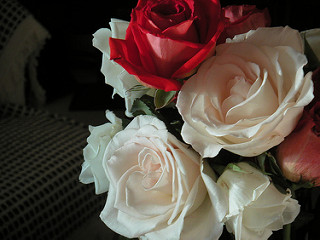

In [4]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[5]))

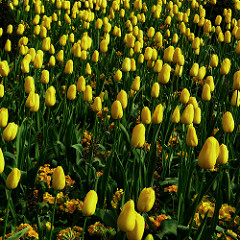

In [5]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[2]))

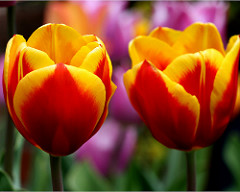

In [6]:
PIL.Image.open(str(tulips[1]))

## Загрузка данных с помощью Keras utility

Загрузим изображения с помощью `tf.keras.utils.image_dataset_from_directory`. При желании вы также можете написать собственный код загрузки данных с нуля, посетив [Загрузка и предобработка изображений](../load_data/images.ipynb) tutorial.

### Создание датасета

Определим некоторые параметры для обучения

In [7]:
batch_size = 32 # Размер пакета обучения
img_height = 180 # Высота изображения из обучающей выборки
img_width = 180 # Ширина изображения

При разработке модели рекомендуется использовать разделение датасета. В данном случае 80% изображений используется для обучения и 20% для проверки.

In [8]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [9]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


Вы можете найти имена классов в атрибуте `class_names` в этих наборах данных. Они соответствуют именам каталогов в алфавитном порядке.

In [10]:
class_names = train_ds.class_names
print("Имена классов: ", class_names, "соответсвует выходному значению Y")

Имена классов:  ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'] соответсвует выходному значению Y


## Визуализация данных

Первые девять изображений из обучающего набора данных:

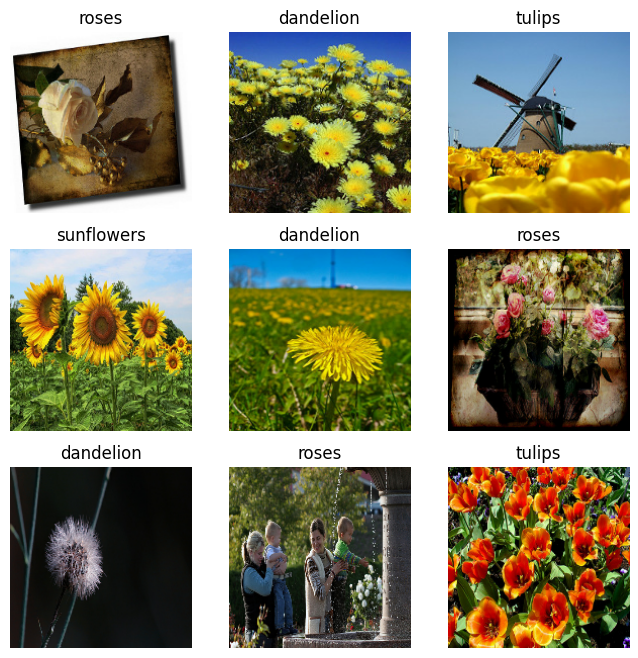

In [11]:
plt.figure(figsize=(8, 8))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

Далее набор данных передаётся в метод `Model.fit`.

In [12]:
for image_batch, labels_batch in train_ds:
  print("Входные параметры: ", image_batch.shape)
  print("Размерность меток", labels_batch.shape)
  break

Входные параметры:  (32, 180, 180, 3)
Размерность меток (32,)


## Настройка набора данных для производительности

- `Dataset.cache` хранит изображения в памяти после их загрузки с диска в течение первой эпохи. Это гарантирует, что набор данных не станет узким местом при обучении модели. Если набор данных слишком велик, чтобы поместиться в память, то можно использовать этот метод для создания производительного кэша на диске.
- `Dataset.prefetch` перекрывает предварительную обработку данных и выполнение модели во время обучения.

In [13]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Стандартизация данных

Значения канала RGB находятся в диапазоне `[0, 255]`. Для корректной работы нейросети это нежелательно, поэтому данные скилируютяс в диапазон от 0 до 1 при помощи метода `tf.keras.layers.Rescaling`.

In [14]:
normalization_layer = layers.Rescaling(1./255)

Есть два способа использования этого слоя. Вы можете применить его к датасету, вызвав `Dataset.map`:

In [15]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Обратите внимание, что значения пикселей теперь находятся в диапазоне [0,1]
print(np.min(first_image), np.max(first_image))

0.0 1.0


*Или* вы можете включить слой в определение вашей модели, что может упростить развертывание. Здесь используется второй подход.

Ранее вы изменяли размер изображений, используя аргумент `image_size` `tf.keras.utils.image_dataset_from_directory`. Если вы хотите включить в свою модель логику изменения размера, вы можете использовать слой `tf.keras.layers.Resizing`.

## Базовая модель в Keras

### Создание модели

Модель Keras [Sequential] (https://www.tensorflow.org/guide/keras/sequential_model) состоит из трех блоков свертки (`tf.keras.layers.Conv2D`) с максимальным объединяющим слоем (`tf.keras. layers.MaxPooling2D`) в каждом из них. Существует полносвязный слой (`tf.keras.layers.Dense`) со 128 единицами поверх него, который активируется функцией активации ReLU (`'relu'`). Эта модель не была настроена на высокую точность; цель этого руководства — показать стандартный подход.

In [16]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

### Компиляция модели

В этом руководстве выбран оптимизатор `tf.keras.optimizers.Adam` и функцию потерь `tf.keras.losses.SparseCategoricalCrossentropy`. Чтобы просмотреть точность обучения и проверки для каждой эпохи обучения, передайте аргумент `metrics` в `Model.compile`.

In [17]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Резюме модели

Просмотреть все слои сети, используя метод Keras `Model.summary`:

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Тренировка модели

Обучение модели в течение 10 эпох с помощью метода `Model.fit`

In [19]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 16s 52ms/step - loss: 1.2654 - accuracy: 0.4707 - val_loss: 1.1297 - val_accuracy: 0.5259
Epoch 2/10
92/92 [==============================] - 3s 27ms/step - loss: 0.9776 - accuracy: 0.6144 - val_loss: 0.9986 - val_accuracy: 0.5872
Epoch 3/10
92/92 [==============================] - 2s 20ms/step - loss: 0.7777 - accuracy: 0.7054 - val_loss: 0.9338 - val_accuracy: 0.6362
Epoch 4/10
92/92 [==============================] - 2s 21ms/step - loss: 0.6076 - accuracy: 0.7738 - val_loss: 0.9550 - val_accuracy: 0.6526
Epoch 5/10
92/92 [==============================] - 2s 20ms/step - loss: 0.3827 - accuracy: 0.8702 - val_loss: 0.9745 - val_accuracy: 0.6689
Epoch 6/10
92/92 [==============================] - 2s 20ms/step - loss: 0.2253 - accuracy: 0.9220 - val_loss: 1.1840 - val_accuracy: 0.6403
Epoch 7/10
92/92 [==============================] - 2s 22ms/step - loss: 0.1312 - accuracy: 0.9622 - val_loss: 1.2139 - val_accuracy: 0.6635
Epoch 8/10
9

## Виуализация результатов обучения

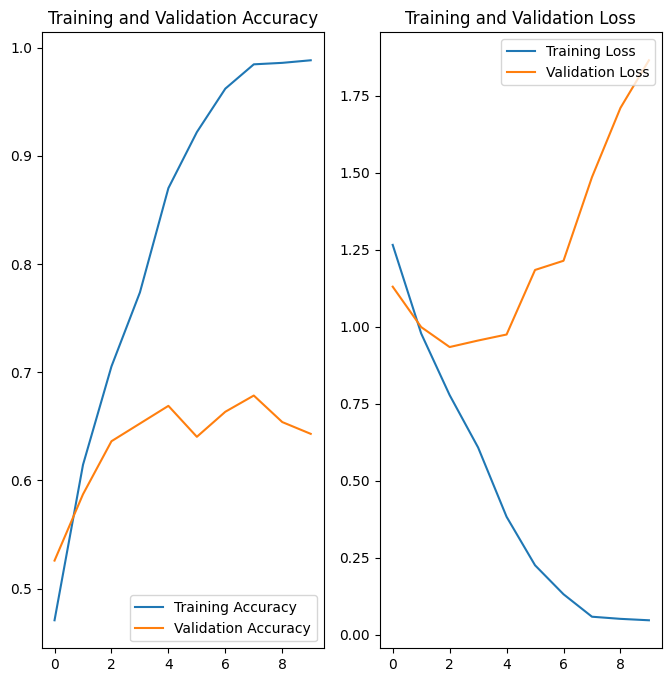

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Графики показывают, что training accuracy и validation accuracy сильно отличаются друг от друга, и модель достигла только около 60% точности на проверочном (validation) наборе.

В следующих разделах руководства показано, как проверить, что пошло не так, и попытаться повысить общую производительность модели.

## Переобучение

На приведенных выше графиках точность обучения линейно увеличивается с течением времени, тогда как точность проверки останавливается примерно на 60% в процессе обучения. Кроме того, заметна разница в точности между точностью training и validation [переоснащения] (https://www.tensorflow.org/tutorials/keras/overfit_and_underfit).

Когда имеется небольшое количество обучающих примеров, модель иногда учится на шумах или нежелательных деталях обучающих примеров — до такой степени, что это негативно влияет на производительность модели на новых примерах. Это явление известно как переоснащение. Это означает, что модели будет трудно обобщить новый набор данных.

## Увеличение данных

Переобучение обычно происходит, когда имеется небольшое количество обучающих примеров. [Увеличение данных](./data_augmentation.ipynb) использует подход создания дополнительных обучающих данных из ваших существующих примеров путем их увеличения с использованием случайных преобразований, которые дают правдоподобно выглядящие изображения. Это помогает представить модель большему количеству аспектов данных и лучше обобщить.

Вы будете реализовывать увеличение данных, используя следующие слои предварительной обработки Keras: `tf.keras.layers.RandomFlip`, `tf.keras.layers.RandomRotation` и `tf.keras.layers.RandomZoom`. Они могут быть включены в вашу модель, как и другие слои, и работать на графическом процессоре.

In [21]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

*Визуализация* нескольких дополненных примеров, применяя увеличение данных к одному и тому же изображению несколько раз:

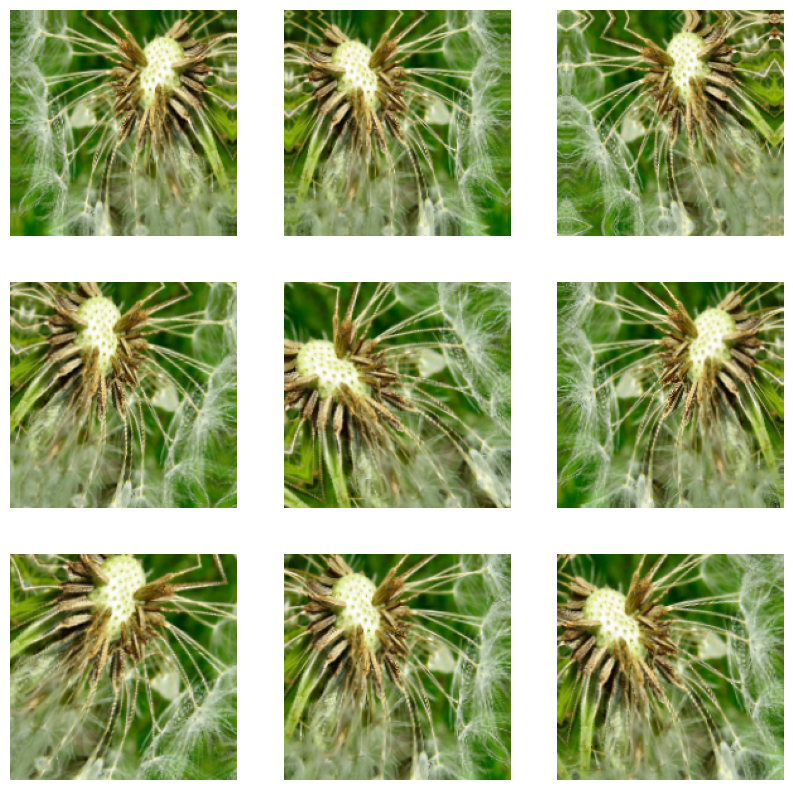

In [22]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

Добавление увеличеных данных в свою модель перед обучением.

## Dropout

Еще один способ уменьшить переоснащение – ввести в сеть [Dropout, отсев](https://developers.google.com/machine-learning/glossary#dropout_regularization){:.external} регуляризацию.

Когда вы применяете выпадение к слою, оно случайным образом выбрасывает (путем установки активации на ноль) количество выходных единиц из слоя в процессе обучения. Dropout принимает дробное число в качестве входного значения, например, 0,1, 0,2, 0,4 и т. д. Это означает случайное удаление 10%, 20% или 40% выходных единиц из примененного слоя.

Создайте новую нейронную сеть с помощью `tf.keras.layers.Dropout` перед ее обучением с использованием дополненных изображений:

In [23]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

## Компиляция и обучение модели

In [24]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [25]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [27]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
92/92 [==============================] - 6s 32ms/step - loss: 1.4159 - accuracy: 0.3849 - val_loss: 1.2055 - val_accuracy: 0.4700
Epoch 2/15
92/92 [==============================] - 3s 29ms/step - loss: 1.0232 - accuracy: 0.6104 - val_loss: 1.0023 - val_accuracy: 0.5926
Epoch 3/15
92/92 [==============================] - 3s 29ms/step - loss: 0.9459 - accuracy: 0.6332 - val_loss: 0.9791 - val_accuracy: 0.6008
Epoch 4/15
92/92 [==============================] - 3s 30ms/step - loss: 0.8845 - accuracy: 0.6499 - val_loss: 0.8932 - val_accuracy: 0.6662
Epoch 5/15
92/92 [==============================] - 3s 29ms/step - loss: 0.8162 - accuracy: 0.6843 - val_loss: 0.8824 - val_accuracy: 0.6540
Epoch 6/15
92/92 [==============================] - 3s 32ms/step - loss: 0.7839 - accuracy: 0.6999 - val_loss: 0.8568 - val_accuracy: 0.6471
Epoch 7/15
92/92 [==============================] - 3s 30ms/step - loss: 0.7545 - accuracy: 0.7176 - val_loss: 0.8352 - val_accuracy: 0.6649
Epoch 8/15
92

## Визуализация результатов обучения

После применения аугментации данных и `tf.keras.layers.Dropout` величина переобучения меньше, соответсвенно показатели точности становятся выше.

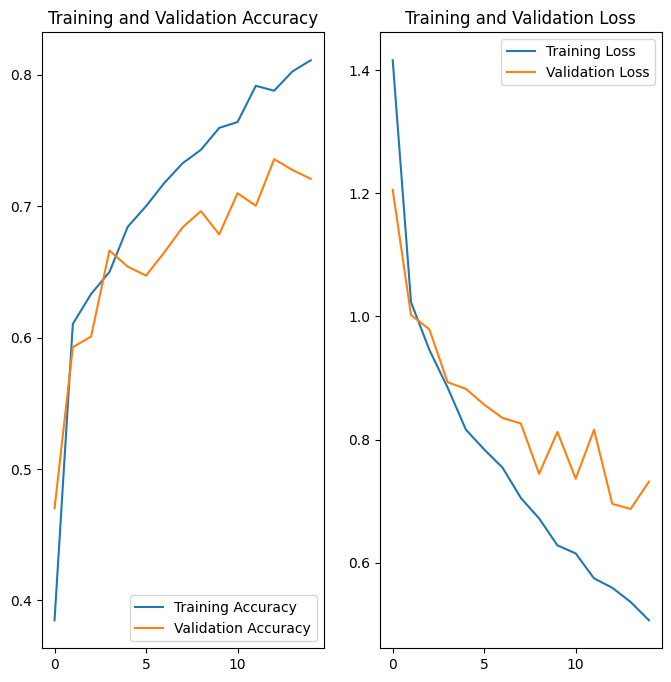

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Создания новых предсказаний

Далее модель используется для классификации изображения, которое не было включено в наборы для обучения или проверки.

Примечание. Слои Data augmentation и dropout неактивны во время вывода.


In [34]:
#Загрузим изображение подсолнуха
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
# Определим путь до него
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img) # Переведём изображение в массив пикселей
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array) # Сделаем предсказание при помощи ранее обученной модели
score = tf.nn.softmax(predictions[0]) # Определим процентаж

print("Данное изображение скорее всего {} с  вероятностью {:.2f} % "
    .format(class_names[np.argmax(score)], 100 * np.max(score)))

1/1 [==============================] - 0s 19ms/step
Данное изображение скорее всего sunflowers с  вероятностью 99.58 % 
